In [1]:
!pip install fbprophet

In [2]:
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import io, base64, os, json, re, glob
import datetime
from datetime import timedelta
import pandas as pd
import pydata_google_auth
import numpy as np
sns.set()

from fbprophet import Prophet
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
path = '/content/drive/My Drive/'
#file = 'SCADA_data_WT2339.csv'
file = 'SCADA_data_WT2337.csv'
df_raw = pd.read_csv(path+file,
                   low_memory=False)
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'], format="%Y/%m/%d %H:%M:%S")
df_raw = df_raw.sort_values(by='date_time')
df_raw.tail()

,id,ld_id,date_time,fake_data,NumSampleTenMinBin,AcumGralPala1Mean,AcumGralPala1Sdev,AcumGralPala1Min,AcumGralPala1Max,AcumGralPala2Mean,AcumGralPala2Sdev,AcumGralPala2Min,AcumGralPala2Max,AcumGralPala3Mean,AcumGralPala3Sdev,AcumGralPala3Min,AcumGralPala3Max,AutopilotoCalc,CmdWTGMean,CmdWTGSdev,CmdWTGMin,CmdWTGMax,ConfirmContractGiroCCWMean,ConfirmContractGiroCCWSdev,ConfirmContractGiroCCWMin,ConfirmContractGiroCCWMax,ConfirmContractGiroCWMean,ConfirmContractGiroCWSdev,ConfirmContractGiroCWMin,ConfirmContractGiroCWMax,ContEnerActivaMean,ContEnerActivaSdev,ContEnerActivaMin,ContEnerActivaMax,CosPhiMean,CosPhiSdev,CosPhiMin,CosPhiMax,Diag1_R4Mean,Diag1_R4Sdev,...,TempRodamTraseroMin,TempRodamTraseroMax,TempTrafo1Mean,TempEjeLento_2,TempEjeLento_1,TempTrafo1Sdev,TempTrafo1Min,TempTrafo1Max,TempTrafo2Mean,TempTrafo2Sdev,TempTrafo2Min,TempTrafo2Max,TempTrafo3Mean,TempTrafo3Sdev,TempTrafo3Min,TempTrafo3Max,TensRedMean,TensRedSdev,TensRedMin,TensRedMax,TotPotReactMean,TotPotReactSdev,TotPotReactMin,TotPotReactMax,VelGenMean,VelGenSdev,VelGenMin,VelGenMax,VelRotorMean,VelRotorSdev,VelRotorMin,VelRotorMax,VelVientoMean,VelVientoSdev,VelVientoMin,VelVientoMax,YawMean,YawSdev,YawMin,YawMax
358129,8839604,2337,2019-10-28 00:10:00,0,600,221.954,4.63100,216.008,229.347,217.778,5.31917,212.150,228.865,221.664,5.41738,216.811,230.151,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,536879000.0,0.0,536879000.0,536879000.0,48887800.0,9.02790,48887800.0,48887900.0,-0.980430,0.000304,-0.980957,-0.979903,-50.0,0.0,...,23.2861,23.3034,46.9509,NaN,NaN,0.016494,46.9223,46.9795,48.4273,0.012611,48.4054,48.4491,47.4994,0.00882,47.4842,47.5147,11957.3,10.93350,11938.4,11976.2,-36.4999,4.838030,-45.0,-27.6733,805.967,9.70336,784.700,821.600,12.1454,0.224825,11.65,12.5500,6.43641,0.380473,5.50595,7.69220,230.350,0.393876,230.0,231.000
358130,8839605,2337,2019-10-28 00:20:00,0,600,223.804,4.64977,212.633,229.508,219.122,4.53024,210.543,229.026,224.706,5.20570,212.150,230.472,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,536879000.0,0.0,536879000.0,536879000.0,48887900.0,9.02533,48887900.0,48887900.0,-0.981484,0.000304,-0.982011,-0.980957,-50.0,0.0,...,23.3034,23.3207,46.8938,NaN,NaN,0.016494,46.8652,46.9223,48.3836,0.012611,48.3617,48.4054,47.4689,0.00882,47.4536,47.4842,11919.4,10.93350,11900.5,11938.4,-34.5572,0.831516,-36.0,-32.0000,803.277,11.44820,784.800,833.400,12.1656,0.209943,11.65,12.5500,6.58290,0.365419,5.42725,7.47053,230.447,0.262528,230.0,231.000
358131,8839606,2337,2019-10-28 00:30:00,0,600,225.495,1.03489,224.526,228.696,218.783,2.84479,214.722,225.875,225.068,1.11925,223.722,228.495,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,536879000.0,0.0,536879000.0,536879000.0,48887900.0,7.82821,48887900.0,48887900.0,-0.977223,0.003708,-0.992405,-0.974732,-50.0,0.0,...,23.3207,23.3380,46.8366,NaN,NaN,0.016494,46.8081,46.8652,48.3399,0.012611,48.3181,48.3617,47.4383,0.00882,47.4231,47.4536,11929.6,19.65790,11892.0,11942.9,-30.9455,2.866030,-41.0,-21.0000,785.961,8.54638,773.300,823.800,11.9320,0.162418,11.72,12.5000,6.36619,0.358527,5.29651,7.20804,230.034,0.078562,230.0,230.325
358132,8839607,2337,2019-10-28 00:40:00,0,600,220.668,4.17242,218.422,229.508,217.708,4.38384,213.115,229.026,221.416,3.95864,219.383,230.472,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,536879000.0,0.0,536879000.0,536879000.0,48887900.0,8.79177,48887900.0,48887900.0,-0.975272,0.000132,-0.975500,-0.975044,-50.0,0.0,...,23.3380,23.3668,46.7795,NaN,NaN,0.016494,46.7509,46.8081,48.2962,0.012611,48.2744,48.3181,47.4078,0.00882,47.3925,47.4231,11945.6,1.53415,11942.9,11948.3,-32.7019,1.370700,-34.0,-22.0000,788.743,9.08238,769.000,821.483,11.9673,0.196582,11.72,12.4973,6.40599,0.348583,5.11893,7.42988,230.465,0.327974,230.0,231.000
358133,8839608,2337,2019-10-28 00:50:00,0,600,223.252,6.14983,212.793,229.347,219.251,5.35538,211.260,228.865,223.936,5.88944,213.597,230.312,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,536879000.0,0.0,536879000.0,536879000.0,48888000.0,10.17060,48887900.0,48888000.0,-0.975728,0.000132,-0.975956,-0.97

In [4]:
df_raw.head()

,id,ld_id,date_time,fake_data,NumSampleTenMinBin,AcumGralPala1Mean,AcumGralPala1Sdev,AcumGralPala1Min,AcumGralPala1Max,AcumGralPala2Mean,AcumGralPala2Sdev,AcumGralPala2Min,AcumGralPala2Max,AcumGralPala3Mean,AcumGralPala3Sdev,AcumGralPala3Min,AcumGralPala3Max,AutopilotoCalc,CmdWTGMean,CmdWTGSdev,CmdWTGMin,CmdWTGMax,ConfirmContractGiroCCWMean,ConfirmContractGiroCCWSdev,ConfirmContractGiroCCWMin,ConfirmContractGiroCCWMax,ConfirmContractGiroCWMean,ConfirmContractGiroCWSdev,ConfirmContractGiroCWMin,ConfirmContractGiroCWMax,ContEnerActivaMean,ContEnerActivaSdev,ContEnerActivaMin,ContEnerActivaMax,CosPhiMean,CosPhiSdev,CosPhiMin,CosPhiMax,Diag1_R4Mean,Diag1_R4Sdev,...,TempRodamTraseroMin,TempRodamTraseroMax,TempTrafo1Mean,TempEjeLento_2,TempEjeLento_1,TempTrafo1Sdev,TempTrafo1Min,TempTrafo1Max,TempTrafo2Mean,TempTrafo2Sdev,TempTrafo2Min,TempTrafo2Max,TempTrafo3Mean,TempTrafo3Sdev,TempTrafo3Min,TempTrafo3Max,TensRedMean,TensRedSdev,TensRedMin,TensRedMax,TotPotReactMean,TotPotReactSdev,TotPotReactMin,TotPotReactMax,VelGenMean,VelGenSdev,VelGenMin,VelGenMax,VelRotorMean,VelRotorSdev,VelRotorMin,VelRotorMax,VelVientoMean,VelVientoSdev,VelVientoMin,VelVientoMax,YawMean,YawSdev,YawMin,YawMax
0,8322946,2337,2013-01-01 00:00:00,0,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8322947,2337,2013-01-01 00:10:00,0,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8322948,2337,2013-01-01 00:20:00,0,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8322949,2337,2013-01-01 00:30:00,0,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8322950,2337,2013-01-01 00:40:00,0,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


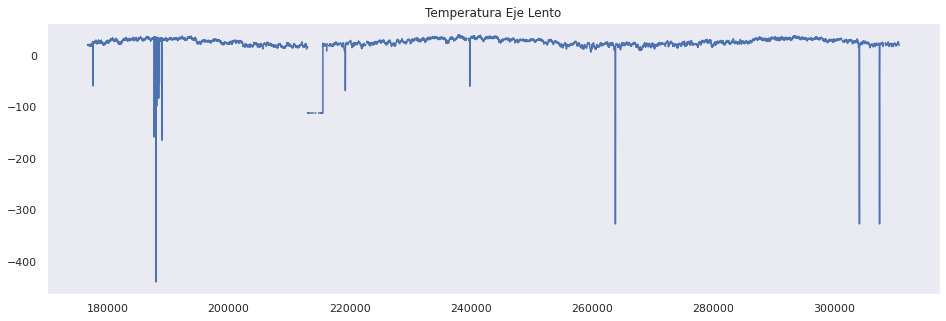

In [5]:
plt.subplots(1, figsize = (16, 5))
plt.grid()
plt.title('Temperatura Eje Lento')
#plt.plot(df_raw['TempEjeLento_1'].rolling(window=150).median())
plt.plot(df_raw['TempEjeLento_1'])

In [6]:
train_dataset = df_raw[['date_time', 'TempEjeLento_1','TempAmbMean','IndTurbulMean','VelVientoMean','VelVientoSdev']]
train_dataset.columns = ["ds", "y",'TempAmbMean','IndTurbulMean','VelVientoMean','VelVientoSdev']
train_dataset=train_dataset.dropna()
train_dataset.head()

,ds,y,TempAmbMean,IndTurbulMean,VelVientoMean,VelVientoSdev
176700,2016-05-12 02:00:00,19.9957,11.3776,6.76504,9.58786,1.31282
176701,2016-05-12 02:10:00,20.0004,11.3292,7.51869,11.00180,2.32537
176702,2016-05-12 02:20:00,20.0078,11.2808,6.73174,11.27410,1.57056
176703,2016-05-12 02:30:00,20.0159,11.2323,7.36748,11.39120,1.88967
176704,2016-05-12 02:40:00,20.0559,11.1839,7.50120,11.71090,1.61023


In [7]:
def remove_outliers(df):
    return df[np.abs(df['y']-df['y'].mean())<=(3*df['y'].std())] 

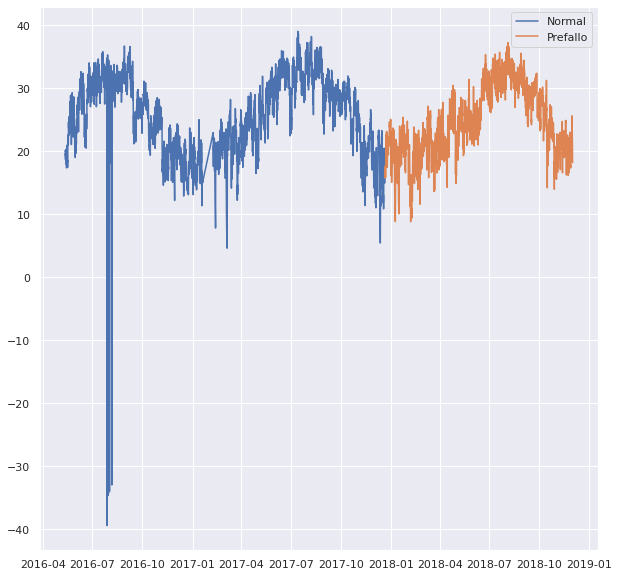

In [8]:
date = '2017-12-21'
date_fail = '2018-05-21'
data_1 = train_dataset[(train_dataset['ds'] < date)]
data_1 = remove_outliers(data_1)

data_2 = train_dataset[(train_dataset['ds'] > date)]
data_2 = remove_outliers(data_2)

data_test = train_dataset[(train_dataset['ds'] < date_fail)]
#data_test = data_test[(data_test['ds'] < date_fail)]
data_test = remove_outliers(data_test)
plt.figure(figsize=(10,10))
plt.plot(data_1['ds'],data_1['y'],label='Normal')
plt.plot(data_2['ds'],data_2['y'],label='Prefallo')
plt.legend()
plt.show()

In [9]:
#prophet_basic = Prophet(yearly_seasonality=True)
prophet_basic = Prophet()
prophet_basic.add_regressor('TempAmbMean')
prophet_basic.add_regressor('IndTurbulMean')
prophet_basic.add_regressor('VelVientoMean')
prophet_basic.add_regressor('VelVientoSdev')
prophet_basic.fit(data_1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


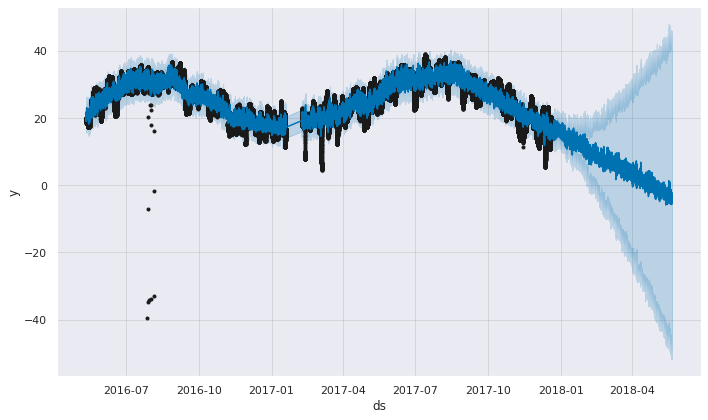

In [10]:
forecast=prophet_basic.predict(data_test.drop(columns="y"))

#Plotting the predicted data
fig1 =prophet_basic.plot(forecast)

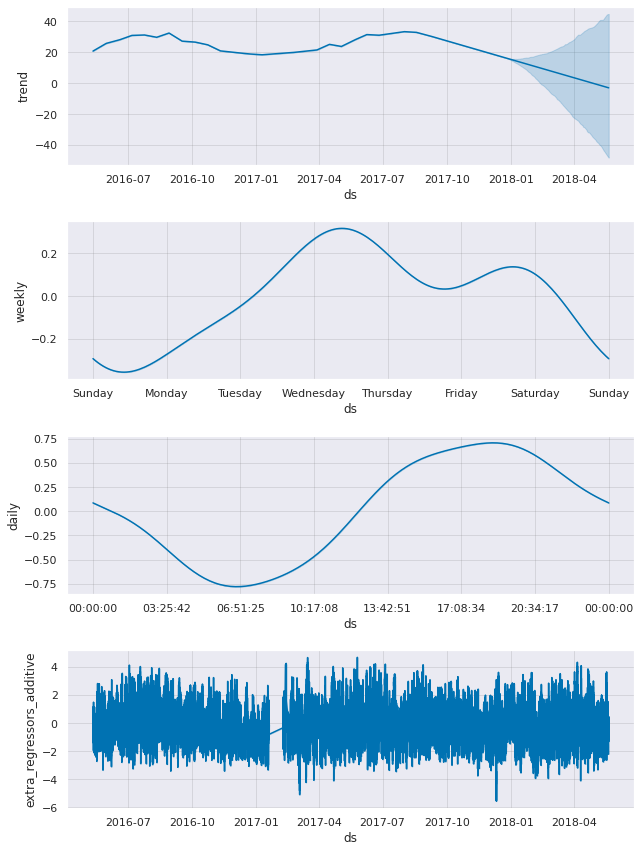

In [11]:
fig1 = prophet_basic.plot_components(forecast)

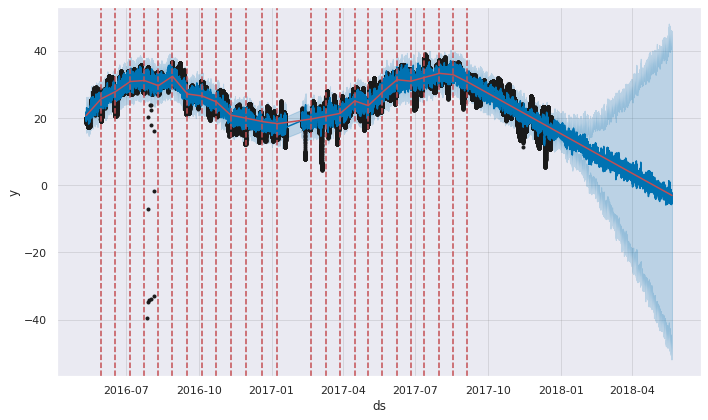

In [12]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

In [13]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,IndTurbulMean,IndTurbulMean_lower,IndTurbulMean_upper,TempAmbMean,TempAmbMean_lower,TempAmbMean_upper,VelVientoMean,VelVientoMean_lower,VelVientoMean_upper,VelVientoSdev,VelVientoSdev_lower,VelVientoSdev_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
98934,2018-05-20 23:10:00,-3.006828,-48.028775,44.570980,-48.199265,44.815684,0.389349,0.389349,0.389349,0.040129,0.040129,0.040129,-0.810860,-0.810860,-0.810860,-0.120917,-0.120917,-0.120917,-0.602688,-0.602688,-0.602688,0.180883,0.180883,0.180883,-0.502299,-0.502299,-0.502299,-0.281272,-0.281272,-0.281272,0.0,0.0,0.0,-3.609516
98935,2018-05-20 23:20:00,-3.007738,-48.831079,43.383775,-48.203597,44.816412,-0.019628,-0.019628,-0.019628,0.040784,0.040784,0.040784,-0.928702,-0.928702,-0.928702,-0.118122,-0.118122,-0.118122,-1.145257,-1.145257,-1.145257,0.160124,0.160124,0.160124,-1.025669,-1.025669,-1.025669,-0.279712,-0.279712,-0.279712,0.0,0.0,0.0,-4.152995
98936,2018-05-20 23:30:00,-3.008648,-48.405340,43.739760,-48.207928,44.817140,0.496833,0.496833,0.496833,0.041439,0.041439,0.041439,-0.591276,-0.591276,-0.591276,-0.120435,-0.120435,-0.120435,-0.311194,-0.311194,-0.311194,0.140391,0.140391,0.140391,-0.173439,-0.173439,-0.173439,-0.278146,-0.278146,-0.278146,0.0,0.0,0.0,-3.319842
98937,2018-05-20 23:40:00,-3.009558,-49.289774,44.299967,-48.212260,44.817868,0.127334,0.127334,0.127334,0.042093,0.042093,0.042093,-1.074284,-1.074284,-1.074284,-0.095798,-0.095798,-0.095798,-1.155633,-1.155633,-1.155633,0.121598,0.121598,0.121598,-1.000655,-1.000655,-1.000655,-0.276575,-0.276575,-0.276575,0.0,0.0,0.0,-4.165191
98938,2018-05-20 23:50:00,-3.010469,-50.127455,42.416039,-48.216592,44.818595,0.152824,0.152824,0.152824,0.042748,0.042748,0.042748,-1.251620,-1.251620,-1.251620,-0.028092,-0.028092,-0.028092,-1.255512,-1.255512,-1.255512,0.103626,0.103626,0.103626,-1.084140,-1.084140,-1.084140,-0.274998,-0.274998,-0.274998,0.0,0.0,0.0,-4.265981


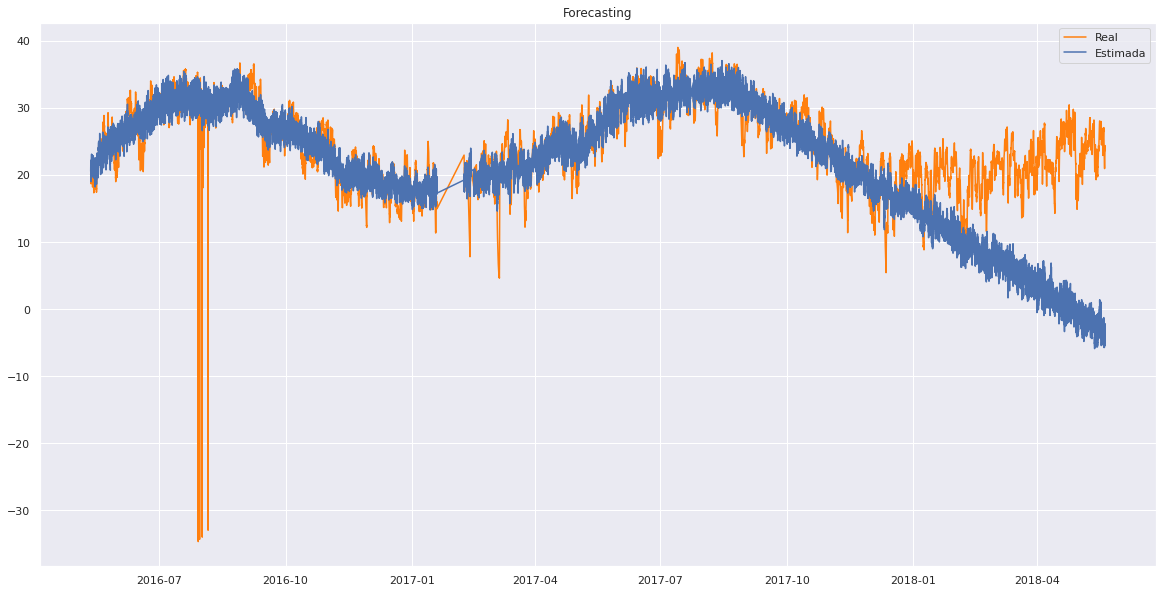

In [14]:
plt.figure(figsize=(20,10))
#plt.plot(forecast['ds'],forecast['yhat_lower'],'-r',label='Confianza')
#plt.plot(forecast['ds'],forecast['yhat_upper'],'-r')
plt.plot(data_test['ds'],data_test['y'],'tab:orange',label='Real')
plt.plot(forecast['ds'],forecast['yhat'],'b',label='Estimada')
#plt.plot(data_1['ds'],data_1['y'],'c')
plt.legend()
plt.title('Forecasting')
plt.show()

In [15]:
import numpy as np
forecast['error']= data_test['y']-forecast['yhat']

In [16]:
data_test.head()

,ds,y,TempAmbMean,IndTurbulMean,VelVientoMean,VelVientoSdev
176700,2016-05-12 02:00:00,19.9957,11.3776,6.76504,9.58786,1.31282
176701,2016-05-12 02:10:00,20.0004,11.3292,7.51869,11.00180,2.32537
176702,2016-05-12 02:20:00,20.0078,11.2808,6.73174,11.27410,1.57056
176703,2016-05-12 02:30:00,20.0159,11.2323,7.36748,11.39120,1.88967
176704,2016-05-12 02:40:00,20.0559,11.1839,7.50120,11.71090,1.61023


In [17]:
forecast['y_true'] = data_test['y'].values
forecast['error'] = forecast['y_true']-forecast['yhat']

In [18]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,IndTurbulMean,IndTurbulMean_lower,IndTurbulMean_upper,TempAmbMean,TempAmbMean_lower,TempAmbMean_upper,VelVientoMean,VelVientoMean_lower,VelVientoMean_upper,VelVientoSdev,VelVientoSdev_lower,VelVientoSdev_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,error,y_true
0,2016-05-12 02:00:00,20.761682,17.306137,23.703496,20.761682,20.761682,-2.121867,-2.121867,-2.121867,0.069362,0.069362,0.069362,1.638157,1.638157,1.638157,0.177018,0.177018,0.177018,-0.208110,-0.208110,-0.208110,-0.139577,-0.139577,-0.139577,-0.237330,-0.237330,-0.237330,0.168797,0.168797,0.168797,0.0,0.0,0.0,20.553572,-0.557872,19.9957
1,2016-05-12 02:10:00,20.763532,17.651239,24.559019,20.763532,20.763532,-2.740559,-2.740559,-2.740559,0.069707,0.069707,0.069707,2.455811,2.455811,2.455811,0.540368,0.540368,0.540368,0.326870,0.326870,0.326870,-0.165002,-0.165002,-0.165002,0.325327,0.325327,0.325327,0.166545,0.166545,0.166545,0.0,0.0,0.0,21.090402,-1.090002,20.0004
2,2016-05-12 02:20:00,20.765383,18.149420,24.724771,20.765383,20.765383,-2.094530,-2.094530,-2.094530,0.070052,0.070052,0.070052,2.613277,2.613277,2.613277,0.269507,0.269507,0.269507,0.830806,0.830806,0.830806,-0.191795,-0.191795,-0.191795,0.858305,0.858305,0.858305,0.164295,0.164295,0.164295,0.0,0.0,0.0,21.596189,-1.588389,20.0078
3,2016-05-12 02:30:00,20.767234,17.947293,24.372110,20.767234,20.767234,-2.616426,-2.616426,-2.616426,0.070397,0.070397,0.070397,2.680993,2.680993,2.680993,0.384019,0.384019,0.384019,0.461134,0.461134,0.461134,-0.219897,-0.219897,-0.219897,0.518983,0.518983,0.518983,0.162049,0.162049,0.162049,0.0,0.0,0.0,21.228368,-1.212468,20.0159
4,2016-05-12 02:40:00,20.769085,17.741946,24.421574,20.769085,20.769085,-2.726201,-2.726201,-2.726201,0.070742,0.070742,0.070742,2.865870,2.865870,2.865870,0.283743,0.283743,0.283743,0.404749,0.404749,0.404749,-0.249211,-0.249211,-0.249211,0.494154,0.494154,0.494154,0.159806,0.159806,0.159806,0.0,0.0,0.0,21.173833,-1.117933,20.0559


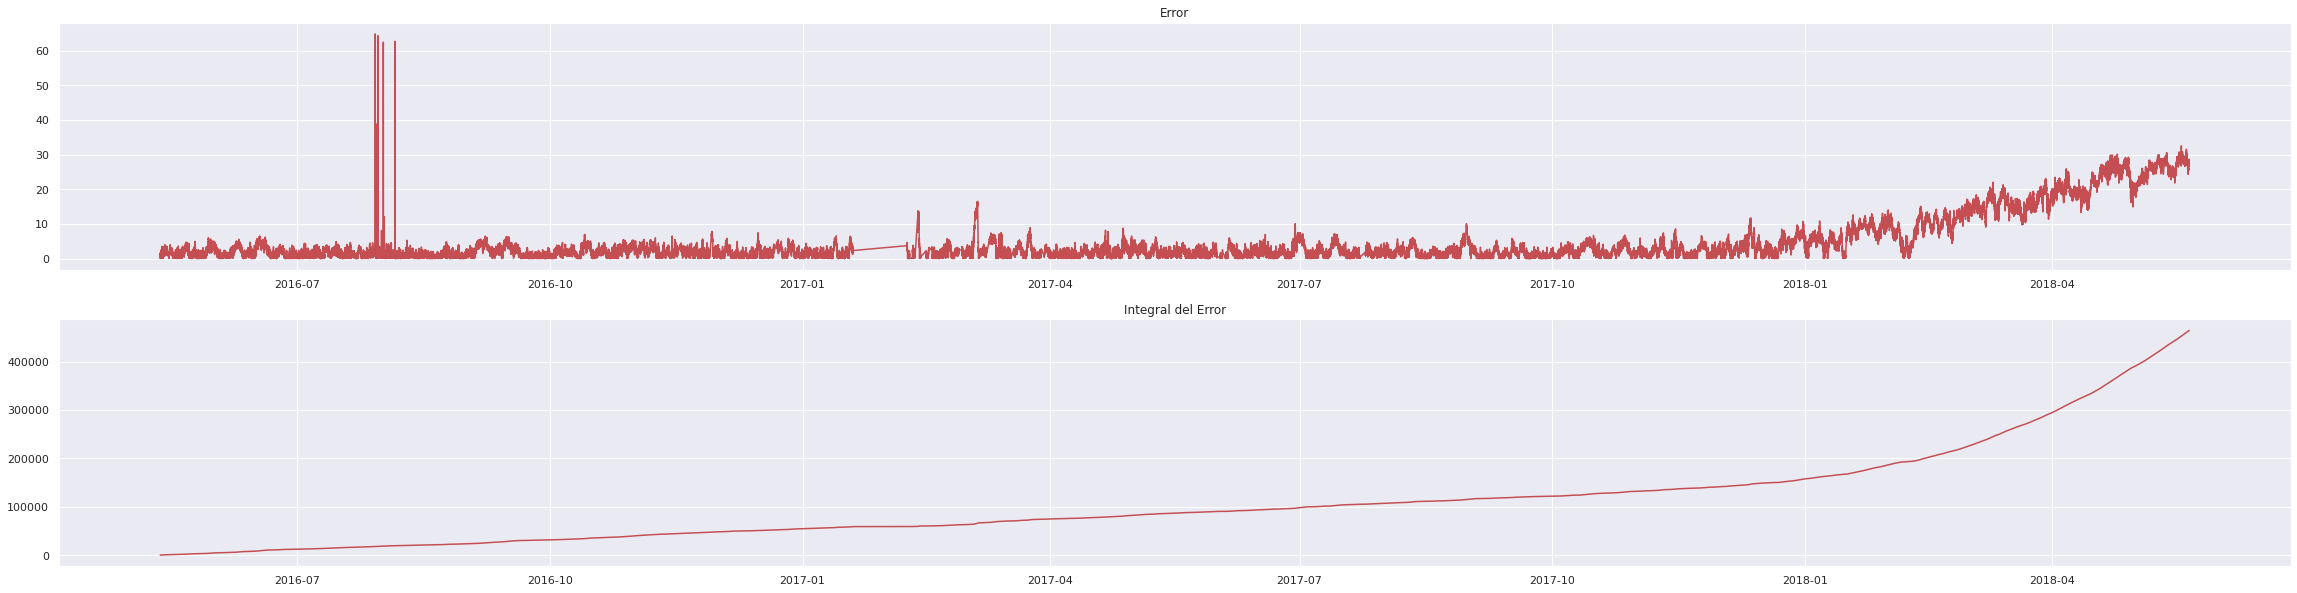

In [19]:
plt.figure(figsize=(40,10))
plt.subplot(211)
plt.title('Error')
plt.plot(forecast['ds'],forecast['error'].abs(),'r')
plt.subplot(212)
plt.title('Integral del Error')
plt.plot(forecast['ds'],forecast['error'].abs().cumsum(),'r')

plt.show()

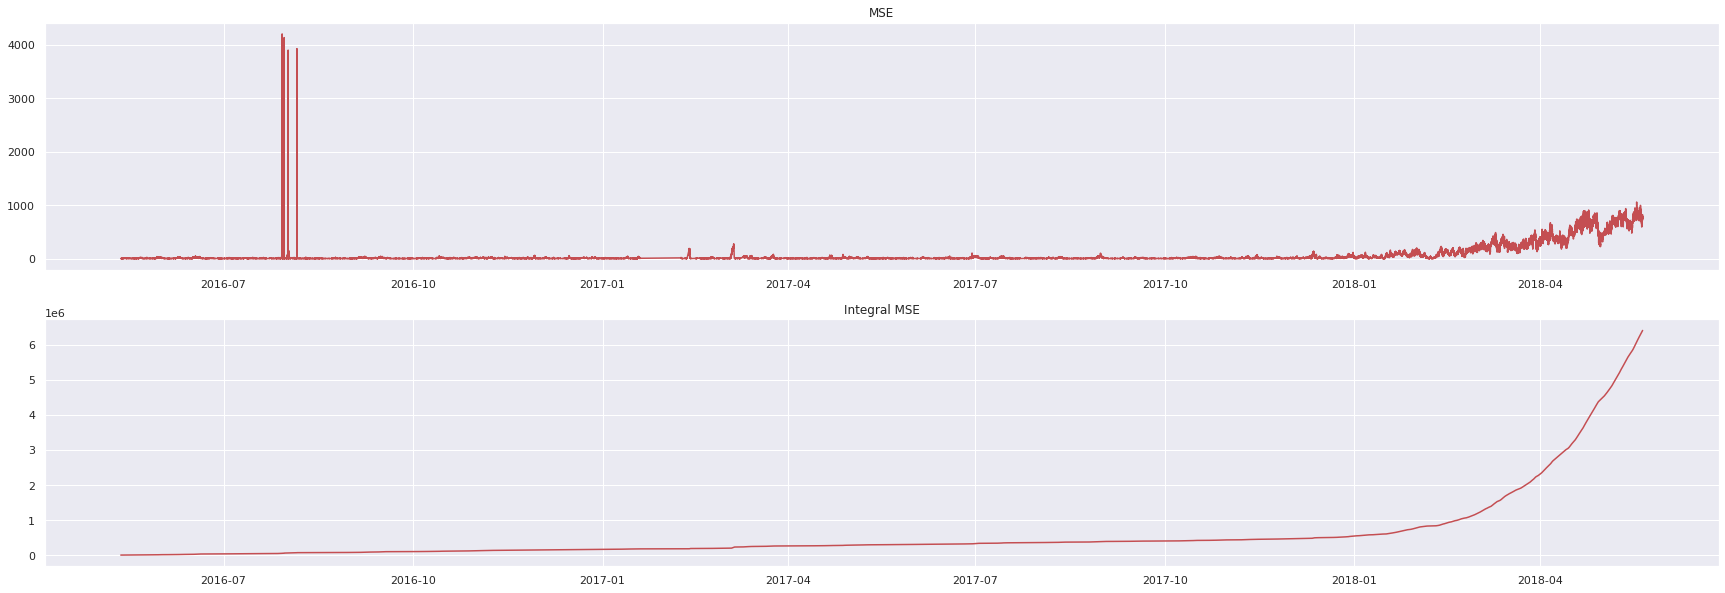

In [20]:
signal = forecast['error']**2
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.plot(forecast['ds'],signal,'r')
plt.title('MSE')
plt.subplot(212)
signal=forecast['error']**2
plt.plot(forecast['ds'],signal.cumsum(),'r')
plt.title('Integral MSE')
plt.show()